# Settings

In [1]:
import numpy as np
import pandas as pd

pd.set_option('max.colwidth', 500)

In [2]:
%reload_ext rpy2.ipython

# Scraping scripts

## Titles only

## Full article info

# Import data

In [3]:
titles = pd.read_csv("/Users/nancy/PycharmProjects/medium-ds-articles/data/raw/medium_titles_2018.csv")

full = pd.read_csv("/Users/nancy/PycharmProjects/medium-ds-articles/data/raw/medium_full_2018.csv")

In [4]:
print("Full:", full.shape)
print("Titles:", titles.shape)

Full: (19698, 9)
Titles: (20127, 2)


# Clean URL in full article data table

In [5]:
full['articleLink'] = full['articleURL'].str.split('?').str[0]

full.drop('articleURL', axis=1, inplace=True)

full.drop_duplicates(subset=['articleLink'], keep='first', inplace=True)

print(full.shape)

(19653, 9)


# Clean URL in titles data table

In [6]:
titles['articleLink'] = titles['articleURL'].str.split('?').str[0]

titles.drop('articleURL', axis=1, inplace=True)

titles.drop_duplicates(subset=['articleLink'], keep='first', inplace=True)

print(titles.shape)

(19678, 2)


# Merge two data tables to get full set of links

In [7]:
merged = full.merge(titles, how='outer', left_on='articleLink', right_on='articleLink' )

merged.drop(['article_x', 'article_y'], axis=1, inplace=True)

# Analyze titles

## Parse URL slugs for title

In [8]:
## Remove NULLs in articleLink column 
merged.dropna(subset=['articleLink'], inplace=True)

In [10]:
for index, row in merged.iterrows():
    for link in row['articleLink'].split('/'):
        if '-' in link:
            words = link.split('-')[:-1]
            merged.loc[index, 'names'] = ' '.join(words)

## Title bigram relationships

### Get title bigrams counts 

In [11]:
import collections
import nltk

import spacy
from spacy_langdetect import LanguageDetector

nlp = spacy.load('en_core_web_sm')

nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)

counts = collections.Counter()

for sent in merged["names"]:
    doc = nlp(sent)
    if doc._.language['language'] == 'en':
        test1 = []
        for token in doc:
            if token.is_alpha:
                test1.append(token.text.lower())
    counts.update(nltk.bigrams(test1))

In [12]:
bigram_counts = pd.DataFrame.from_dict(counts, orient='index').reset_index()

bigram_counts.columns = ["Bigrams", 'Count']

bigram_counts[['Term1', 'Term2']] = pd.DataFrame(bigram_counts['Bigrams'].tolist(), index=bigram_counts.index)  

In [9]:
bigram_counts = bigram_counts[['Term1', 'Term2', 'Count']]

bigram_counts.columns = ['word1', 'word2', 'n']

bigram_counts.sort_values(by='n', ascending=False)

In [20]:
bigram_counts.to_csv("/Users/nancy/PycharmProjects/medium-ds-articles/data/processed/2018_title_bigram_counts.csv", index=False)

### Visualize bigram relationships

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 

library(igraph)

bigram_counts <- read.csv("/Users/nancy/PycharmProjects/medium-ds-articles/data/processed/2018_title_bigram_counts.csv")

bigram_counts <- head(bigram_counts[order(-bigram_counts$n),], 60)

bigram_graph <- bigram_counts %>%
  graph_from_data_frame()

bigram_graph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




IGRAPH 93884b1 DN-- 49 60 -- 
+ attr: name (v/c), n (e/n)
+ edges from 93884b1 (vertex names):
 [1] data        ->science      machine     ->learning    
 [3] how         ->to           a           ->data        
 [5] data        ->scientist    in          ->python      
 [7] deep        ->learning     for         ->data        
 [9] of          ->the          introduction->to          
[11] of          ->data         in          ->the         
[13] the         ->data         what        ->is          
[15] big         ->data         data        ->scientists  
+ ... omitted several edges


R[write to console]: Loading required package: ggplot2

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



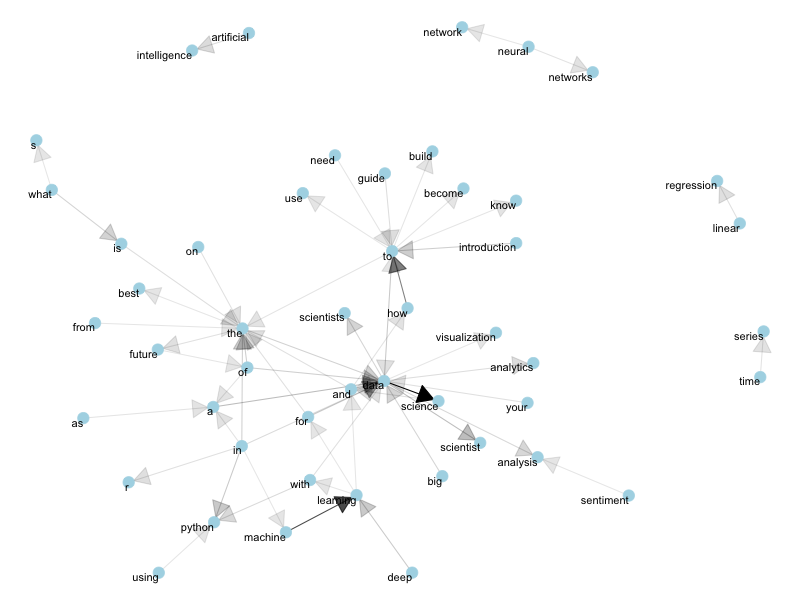

In [4]:
%%R -w 800 -h 600

library(ggraph)

set.seed(2016)

a <- grid::arrow(type = "closed")

options(repr.plot.width=12, repr.plot.height=8)
        
ggraph(bigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()

# Association rule analysis of tags

In [9]:
urls_missing_tags = merged[merged['articleTags'].isnull()]

urls_missing_tags

,NumOfClaps,NumOfComments,articleTags,linkOfAuthorProfile,nameOfAuthor,postingTime,readingTime,articleLink
483,NaN,NaN,NaN,https://medium.com/@newyorktimes,The New York Times,"Jan 4, 2018",5 min read,https://medium.com/the-new-york-times/fake-news-wide-reach-but-little-impact-study-suggests-cd46243ad23a
520,NaN,NaN,NaN,https://medium.com/@Bloomberg_Opinion,Bloomberg Opinion,"Jan 2, 2018",5 min read,https://medium.com/bloomberg-opinion/americans-should-have-more-control-over-their-data-b1a694774e1a
970,NaN,NaN,NaN,https://medium.com/@MITTechReview,MIT Technology Review,"Jan 26, 2018",5 min read,https://medium.com/mit-technology-review/storing-data-in-dna-is-a-lot-easier-than-getting-it-back-out-46dba18e169e
1789,NaN,NaN,NaN,,NaN,"Feb 5, 2018",13 min read,https://medium.com/s/story/how-i-outsmarted-fivethirtyeights-nfl-forecasting-algorithm-592a301fa318
2919,NaN,NaN,NaN,,NaN,"Mar 12, 2018",18 min read,https://medium.com/s/story/the-ultimate-guide-to-filling-out-your-bracket-for-march-madness-9e7d76f16449
3715,NaN,NaN,NaN,,NaN,NaN,,https://upfront.com/thoughts/giving-time-back-to-our-doctors-and-nurses-to-deliver-patient-care-c24b43bfa0a2
3738,NaN,NaN,NaN,https://medium.com/@the_economist,The Economist,"Mar 27, 2018",5 min read,https://medium.com/@the_economist/to-understand-digital-advertising-study-its-algorithms-affefd619d37
3755,NaN,NaN,NaN,,NaN,NaN,,https://blog.gooroo.io/the-cambridge-collusion-manipulating-the-minds-of-the-masses-72f1febf2771
6169,NaN,NaN,NaN,,NaN,"May 7, 2018",6 min read,https://medium.com/s/story/racism-on-stage-at-the-university-of-florida-7244e1f38ca8
7050,NaN,NaN,NaN,,NaN,NaN,,https://www.daylightdata.com/blog/the-gender-wage-gap-fact-vs-myth


## Try to scrape links missing tags --> failed

In [10]:
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy.utils.log import configure_logging
import logging

import os
os.chdir('/Users/nancy/PycharmProjects/medium-ds-articles/data/raw/')

class Article(scrapy.Item):
    nameOfAuthor = scrapy.Field()
    linkOfAuthorProfile = scrapy.Field()
    NumOfComments = scrapy.Field()
    article = scrapy.Field()
    postingTime = scrapy.Field()
    NumOfClaps = scrapy.Field()
    articleURL = scrapy.Field()
    articleTags = scrapy.Field()
    readingTime = scrapy.Field()

logger = logging.getLogger('testlogger')


class IntroSpider(scrapy.Spider):
    name = "intro_spider"


    configure_logging(install_root_handler=False)
    logging.basicConfig(
        filename='medium_full_2018_missing_tags_log.txt',
        format='%(levelname)s: %(message)s',
        level=logging.INFO
    )

    custom_settings = {
        'FEED_FORMAT': 'csv',
        'FEED_URI': 'medium_2018_missing_tags.csv',
        'AUTOTHROTTLE_ENABLED' : True,
        'AUTOTHROTTLE_START_DELAY' : 1,
        'AUTOTHROTTLE_MAX_DELAY' : 3
    }


    def start_requests(self):
        
        for i in urls_missing_tags['articleLink']: 
            yield scrapy.Request(url=i, callback=self.parse)



    def parse(self, response):
        
        item = Article()
        
        #item = response.meta['item']
        item['articleURL'] = response.request.url
#         item['article'] = response.css('div.postArticle-content section div.section-content div h1::text, \
#                                         div.postArticle-content section div.section-content div h1 a::text, \
#                                         div.postArticle-content section div.section-content div h1 strong::text,\
#                                         div.postArticle-content section div.section-content div h1 em::text, \
#                                         div.postArticle-content section div.section-content div h3::text, \
#                                         div.postArticle-content section div.section-content div h4::text, \
#                                         div.postArticle-content section div.section-content div p strong::text, \
#                                         div.postArticle-content section div.section-content div p strong em::text, \
#                                         div.postArticle-content section div.section-content div p::text').extract_first()


#         item['article'] = response.xpath('//div/main/article/div/section/div[2]/div/h1//text() | //div/main/article/div/section/div[2]/div/h4//text() | //div/main/article/div/section/div[2]/div/h1/a//text() | //div/main/article/div/section/div[2]/div/h1/strong//text() | //div/main/article/div/section/div[2]/div/h1/em//text() | //div/main/article/div/section/div[2]/div/p//text()').extract_first()


        try:
            item['linkOfAuthorProfile'] = response.css('div.u-paddingBottom3 a').attrib['href']
        except KeyError:
            item['linkOfAuthorProfile'] = ' '

        if response.css('div.u-paddingBottom3 a').attrib['href']:
            item['linkOfAuthorProfile'] = response.css('div.u-paddingBottom3 a').attrib['href']
        else:
            item['linkOfAuthorProfile'] = response.css('div.u-noWrapWithEllipsis a').attrib['href']


        try:
            item['readingTime'] = response.css('span.readingTime').attrib['title']
        except KeyError:
            item['readingTime'] = ' '

        if response.css('div.u-paddingBottom3 a::text').extract_first():
            item['nameOfAuthor'] = response.css('div.u-paddingBottom3 a::text').extract_first()
        else:
            item['nameOfAuthor'] = response.css('div.u-noWrapWithEllipsis a::text').extract_first()

        item['postingTime'] = response.css('time::text').extract_first()
        item['articleTags'] = response.css('div.u-paddingBottom10 ul.tags--postTags li a::text').getall()
        item['NumOfComments'] = response.css(
            'div.buttonSet.u-flex0 button.button.button--chromeless.u-baseColor--buttonNormal.u-marginRight12::text').extract_first()

        if response.xpath('//div/main/article/footer/div[1]/div[3]/div/div[1]/div/span/button//text()').extract_first():
            item['NumOfClaps'] = response.xpath('//div/main/article/footer/div[1]/div[3]/div/div[1]/div/span/button//text()').extract_first()
        else:
            item['NumOfClaps'] = response.xpath('//div/div[4]/section[2]/div[1]/div/div/div/div[1]/div/span/button/text()').getall()


        yield item


process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(IntroSpider)
process.start()


2019-05-15 10:09:39 [scrapy.utils.log] INFO: Scrapy 1.6.0 started (bot: scrapybot)
2019-05-15 10:09:39 [scrapy.utils.log] INFO: Versions: lxml 4.3.3.0, libxml2 2.9.9, cssselect 1.0.3, parsel 1.5.1, w3lib 1.20.0, Twisted 19.2.0, Python 3.7.1 (default, Dec 14 2018, 13:28:58) - [Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 18.0.0 (OpenSSL 1.1.1b  26 Feb 2019), cryptography 2.4.2, Platform Darwin-18.2.0-x86_64-i386-64bit
2019-05-15 10:09:39 [scrapy.crawler] INFO: Overridden settings: {'AUTOTHROTTLE_ENABLED': True, 'AUTOTHROTTLE_MAX_DELAY': 3, 'AUTOTHROTTLE_START_DELAY': 1, 'FEED_FORMAT': 'csv', 'FEED_URI': 'medium_2018_missing_tags.csv', 'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}
2019-05-15 10:09:39 [scrapy.extensions.telnet] INFO: Telnet Password: a0ccd5549aef0e3d
2019-05-15 10:09:39 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scr

## Prepare tags data

In [14]:
tags = merged['articleTags'].str.split(',', expand=True)

tags = tags.fillna('')

In [16]:
tags.replace('Data Science', '', inplace=True)
tags.replace('Datascience', '', inplace=True)

,0,1,2,3,4,5
0,Data,,Orlando,,,
1,Big Data,,Data Analysis,,,
2,Big Data,Data Analysis,,,,
3,Big Data,Data Analysis,,,,
4,Security,Privacy,Cybersecurity,Compliance,,
5,,,,,,
6,,,,,,
7,,,,,,
8,Big Data,,Data Analysis,,,
9,Science,Reflections,Intelligence Artificielle,,,


In [22]:
tags.to_csv('2018_tags.csv', index=False)

## Itemset mining

In [23]:
%%R 

library(arules)

tr <- read.transactions("2018_tags.csv", format = 'basket', sep=',')

In [24]:
%%R

summary(tr)

transactions as itemMatrix in sparse format with
 19687 rows (elements/itemsets/transactions) and
 6891 columns (items) and a density of 0.0004875017 

most frequent items:
       Machine Learning Artificial Intelligence                  Python 
                   7493                    2957                    2357 
                   Data           Data Analysis                 (Other) 
                   1811                    1519                   49999 

element (itemset/transaction) length distribution:
sizes
    0     1     2     3     4     5     6 
  955   722  1860  2909 13239     1     1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.000   4.000   3.359   4.000   6.000 

includes extended item information - examples:
                 labels
1                     0
2                     1
3 10000 Data Scientists


In [25]:
%%R

itms <- itemFrequency(tr, type = "relative")
data.frame(sort(itms, decreasing = TRUE))

                          sort.itms..decreasing...TRUE.
Machine Learning                           3.806065e-01
Artificial Intelligence                    1.502006e-01
Python                                     1.197237e-01
Data                                       9.198964e-02
Data Analysis                              7.715752e-02
Big Data                                   7.604003e-02
Deep Learning                              7.350028e-02
Data Visualization                         7.309392e-02
Analytics                                  6.024280e-02
Technology                                 5.104892e-02
Statistics                                 5.023620e-02
AI                                         4.480114e-02
Programming                                4.185503e-02
Towards Data Science                       3.327069e-02
NLP                                        2.336567e-02
R                                          2.219739e-02
Startup                                    2.143

In [28]:
%%R

itemsets <- apriori(tr, parameter = list(supp=0.001, conf=0.8, target='frequent', minlen=4))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
         NA    0.1    1 none FALSE            TRUE       5   0.001      4
 maxlen            target   ext
     10 frequent itemsets FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 19 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[6891 item(s), 19687 transaction(s)] done [0.03s].
sorting and recoding items ... [368 item(s)] done [0.00s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [11 set(s)] done [0.00s].
creating S4 object  ... done [0.01s].


In [29]:
%%R

quality(itemsets)$lift <- interestMeasure(itemsets, measure='lift', tr)

inspect(sort(itemsets, by ='count', decreasing = T))

     items                         support count        lift
[1]  {AI,                                                   
      Artificial Intelligence,                              
      Deep Learning,                                        
      Machine Learning}        0.003657236    72   19.427949
[2]  {Artificial Intelligence,                              
      Deep Learning,                                        
      Machine Learning,                                     
      Neural Networks}         0.002234977    44   31.446439
[3]  {Artificial Intelligence,                              
      Deep Learning,                                        
      Machine Learning,                                     
      Towards Data Science}    0.001879413    37   13.443844
[4]  {Artificial Intelligence,                              
      Computer Vision,                                      
      Deep Learning,                                        
      Machine Learning} 